# Generic notebook to implement LSTM

### Foreword

This notebook implements an LSTM model designed for datasets that adhere to a specific structure. The datasets should consist of **time series** data, where each timestamp is associated with sequences of feature values. These sequences represent the behavior of the time series over a defined period.

Each sequence must have the same length and should correspond to the timestamp *t* of its **most recent value**. These feature sequences serve as **predictors**, helping the model forecast an **output sequence**—which contains the values of the time series counting up to a set time period **ahead** *h* of *t*.

As long as these criteria are met, the notebook can be safely executed.

In the following cells, LSTM will be performed over data indicating the level of $SO_{2}$ withing a waste incinerator. The goal is to predict to level of $SO_2$ 2 minutes ahead to see if there is any pollution peak coming up and being able to adjust the level of soda ($NaOH$) to control the peaks. 

### Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go

from plotly_resampler import FigureResampler
from plotly.subplots import make_subplots

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

### Utils

In [2]:
def split_sequences(df, window_size, horizon, n_steps_in, n_steps_out, features, target):
    """This function is designed to transform df into a sequential data set.

    Parameters
    ----------

    df : Pandas DataFrame of shape (n_samples, n_predictors)
        Original data frame with the target feature already shifted by 'horizon'

    window_size : str
        How far we look back to create our sequences for each predictor

    horizon : str
        How far ahead we try to predict

    n_steps_in : int
        Length of each predictor sequence

    n_steps_out : int
        Length of each sequence for the target feature

    predictors : list
        The predictors

    target : list
        The target(s)

    Returns
    -------
    df_sequence : Pandas DataFrame
        Sequential data frame
    """
    X, y, ind = [], [], []

    # We can create both the predictors and target sequences simultaneously using the shifted 'df'. The key is determining
    # whether 'window_size' or 'horizon' is larger. Apply rolling to the larger one, then create the smaller sequence as a
    # subset, trimming any excess data.
    window = max(pd.Timedelta(window_size), pd.Timedelta(horizon))
    max_steps = max(n_steps_in, n_steps_out)
    for df_rolling in df.rolling(window=window):
        if len(df_rolling) == max_steps:  # Ensure we have the correct window size
            seq_x = df_rolling[features].values
            seq_y = df_rolling[f"{target[0]} - TARGET"].values

            # Prune the sequences
            if n_steps_in <= n_steps_out:
                seq_x = seq_x[-n_steps_in:]
            else:
                seq_y = seq_y[-n_steps_out:]

            # Check for NaN values
            if not (np.isnan(seq_x).any() or np.isnan(seq_y).any()):
                X.append(seq_x)
                y.append(seq_y)
                ind.append(df_rolling.index[-1])

    # Create DataFrames for the features and target sequences
    df_X = pd.DataFrame({f"{feature}": [seq[:, i] for seq in X] for i, feature in enumerate(features)}, index=ind)
    df_y = pd.DataFrame({f"{tgt} - TARGET": [seq for seq in y] for tgt in target}, index=ind)  # Assuming 1D target

    # Combine feature and target DataFrames
    df_sequence = pd.concat([df_X, df_y], axis=1)

    return df_sequence

In [3]:
# TimeSeriesDataSet is used to prepare the dataset for training with PyTorch, this class takes care of the variable
# transformation, random sampling, and missing value filling, etc.


# Source : https://www.kaggle.com/code/aneridalwadi/time-series-with-pytorch
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

### Format your data accordingly to the foreword

Here we give an plain example of preprocessing on a time series that follows the evolution of the bitcoin price. Once the preprocessing done we will run our LSTM. We try to predict a global tendancy of the bitcoin's price.

In [4]:
# Define some parameters
window_size = "2min"  # How far we look back
horizon = "2min"  # How far ahead we try to predict
n_steps_in = 12  # How long each predictor sequence must be to contain all the points within the window
n_steps_out = 12  # How long each output sequence must be to contain all the points to arrive at the horizon
batch_size = 30  # Number of sequences passed to the LSTM at each iteration (not each epoch !) it allows to update the weights and biases in a more robust manner

*Define your predictors and targets there and the data attached to it*

In [7]:
# Separate the predictors from the target
X, y = df_to_parse.copy(), df_to_parse[target]

In [8]:
# Scale the predictors
ss = StandardScaler()
X_scaled = pd.DataFrame(ss.fit_transform(X), index=df_to_parse.index, columns=predictors)

# Shift the target values
y_shifted = y.shift(freq=f"-{horizon}")
y_shifted.rename(columns={f"{target[0]}": f"{target[0]} - TARGET"}, inplace=True)

# Initialize the data frame with the scaled values and the target shifted by an hour so that we have in the target column the values
# of temperature ahead by an hour (variable horizon).
df_lstm = pd.concat([X_scaled, y_shifted], axis=1, join="inner")

In [9]:
df_sequence = split_sequences(
    df_lstm,
    window_size,
    horizon,
    n_steps_in,
    n_steps_out,
    predictors,
    target,
)

In [10]:
# Split between train and test

# Select the training data based on the given date
df_train = X[X.index < "2023-08-07"].loc[:, predictors]

# Find indices where the target value exceeds the threshold
matching_indices = df_train[df_train[target[0]] > 50].index
list_train_periods = []

# Extend each matching index to include 1 hour before and 1 hour after
for idx in matching_indices:
    start = idx - pd.Timedelta(hours=1.5)
    end = idx + pd.Timedelta(hours=1.5)

    # Add valid indices to the list
    df_idx = df_sequence[(df_sequence.index >= start) & (df_sequence.index <= end)]
    list_train_periods.append(df_idx)

# Remove duplicates and sort the indices
df_train = pd.concat(list_train_periods)
mask_idx = df_train.index.duplicated()

# Now select the rows in df_sequence using the valid indices
X_train = df_train.loc[~mask_idx, predictors]
y_train = df_train.loc[~mask_idx, f"{target[0]} - TARGET"]

# Select the test data as usual
X_test = df_sequence[df_sequence.index >= "2023-08-07"].loc[:, predictors]
y_test = df_sequence[df_sequence.index >= "2023-08-07"].loc[:, f"{target[0]} - TARGET"]

In [11]:
# Reformat the train and test since Data Frame does not understand arrays
X_train_formatted = np.array([np.stack(row) for row in X_train.to_numpy()])
y_train_formatted = np.array([np.stack(row) for row in y_train.to_numpy()])

X_test_formatted = np.array([np.stack(row) for row in X_test.to_numpy()])
y_test_formatted = np.array([np.stack(row) for row in y_test.to_numpy()])

# Convert it to tensor
# Setting 'required_grad' to true helps to track all the operations performed on the tensor, essential for performing
# back propagation.

# Source : https://stackoverflow.com/questions/72113541/utility-of-wrapping-tensor-in-variable-with-requires-grad-false-in-legacy-pytorc
X_train_tensors = torch.tensor(X_train_formatted, requires_grad=True).float()
y_train_tensors = torch.tensor(y_train_formatted, requires_grad=True).float()
X_test_tensors = torch.tensor(X_test_formatted, requires_grad=True).float()
y_test_tensors = torch.tensor(y_test_formatted, requires_grad=True).float()

# Convert it to torch Dataset
train_dataset = TimeSeriesDataset(X_train_tensors, y_train_tensors)
test_dataset = TimeSeriesDataset(X_test_tensors, y_test_tensors)

# Create train and test loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Modelling

Here will be implemented the LSTM...

### Utils

In [12]:
# Source : https://freedium.cfd/https://charlieoneill.medium.com/predicting-the-price-of-bitcoin-with-multivariate-pytorch-lstms-695bc294130
class LSTM(nn.Module):

    def __init__(self, output_size, input_size, hidden_size, num_layers):
        super().__init__()
        self.output_size = output_size  # output size
        self.num_layers = num_layers  # number of recurrent layers in the lstm
        self.input_size = input_size  # input size (i.e. the length of each sequence)
        self.hidden_size = hidden_size  # LSTM units in each lstm layer (also called the number of neurons in each layer)
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)  # LSTM
        self.fc_1 = nn.Linear(hidden_size, 128)  # fully connected
        self.fc_2 = nn.Linear(128, output_size)  # fully connected last layer
        self.relu = nn.ReLU()

    def forward(self, x):
        # hidden state also called the short-memory term which is the output given at the end of each LSTM unit
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # cell state also called the long-memory term which helps compute the output of each LSTM unit
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        _, (hn, _) = self.lstm(x, (h_0, c_0))  # We only keep the hidden state since it is the output given by the LSTM model
        hn = hn[-1]  # Get the hidden features from the last layer of the LSTM
        out = self.relu(hn)  # Apply ReLU
        out = self.fc_1(out)  # First fully-connect layer
        out = self.relu(out)  # Apply ReLU
        out = self.fc_2(out)  # Second fully-connect layer (output layer)
        return out

In [13]:
class EarlyStopping:
    def __init__(self, patience, delta):
        self.patience = patience  # Max number of epoch allowed with no improvement
        self.delta = delta  # Minimum improvement that should observed between two epochs to reset the patience
        self.best_score = None
        self.early_stop = False  # Wether we perform early stopping or not
        self.counter = 0  # Count the number of epoch of no improvement after the last improvement
        self.best_model_state = None  # Save the best model parameters

    def __call__(self, val_loss, model):
        score = val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score > (100 - self.delta) / 100 * self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

In [14]:
# Source 1 : https://pytorch.org/docs/stable/notes/autograd.html#locally-disable-grad-doc
# Source 2 : https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739


def train_one_epoch(model, train_loader, loss_function, epoch, optimizer):
    """This function trains the model on the train loader using batch iteration.

    Parameters
    ---------
    model : LSTM
        LSTM model

    train_loader : DataLoader
        Contains the train data in a DataLoader format

    loss_function : PyTorch loss function
        A loss function to assess how the model performed on each batch

    epoch : int
        Indicates the current epoch

    optimizer : PyTorch optimizer
        Optimizer used to adjust the weights minimizing the loss

    Returns
    -------
    avg_loss_across_batches : float
        Returns the average loss for the last 100 (or less if the epoch has not gone through at least 100) batches
    """

    # Even if at first sight we do not absolutely need it, it is a good practice because I quote 'because the module you are using
    # might be updated to behave differently in training and eval modes' (cf. Source 1).
    model.train(True)  # Set the model to 'training mode'. It allows dropout layers to set a fraction of each batch to 0
    # On 'training mode' batch normalization layer compute the mean and the variance to improve gradient flow and avoid
    # exploding/ vanishing gradient descent (cf. Source 1 - 2)

    print(f"Epoch: {epoch + 1}")
    running_loss = 0.0
    one_batch = False  # See if it completes at least 100 batches

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0], batch[1]
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        loss_sqrt = torch.sqrt(loss)
        running_loss += loss_sqrt.item()

        optimizer.zero_grad()  # Resets the gradient before computing back propagation
        loss.backward()  # Computes back propagation
        optimizer.step()  # Updates the model parameters

        if batch_index % 100 == 99:  # Print every 100 batches
            one_batch = True
            avg_loss_across_batches = running_loss / 100
            print(
                "Batch {0}, Sqrt {1} : {2:.3f}".format(batch_index + 1, type(loss_function).__name__, avg_loss_across_batches)
            )
            running_loss = 0.0
    print()
    if not one_batch:
        avg_loss_across_batches = running_loss / batch_index
    return avg_loss_across_batches

In [15]:
# Source : https://pytorch.org/docs/stable/generated/torch.no_grad.html
def validate_one_epoch(model, test_loader, loss_function):
    """This functions computes and prints the square root of the average loss across all the batches.

    Parameters
    ----------
    model : LSTM
        LSTM model

    test_loader : DataLoader
        Contains the test data in a DataLoader format

    loss_function : PyTorch loss function
        A loss function to assess how the model performed on each batch
    """
    model.train(False)  # Set it to False since we are in evaluation mode
    running_loss = 0.0

    for _, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0], batch[1]

        with torch.no_grad():  # No gradient descent needed since we are in evaluation mode we use the weigths and biases fitted in the train
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            loss_sqrt = torch.sqrt(loss)
            running_loss += loss_sqrt.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print("Val Sqrt. {0} : {1:.3f}".format(type(loss_function).__name__, avg_loss_across_batches))
    print("***************************************************")
    print()

In [16]:
# Define the LSTM parameters
input_size = 12
output_size = 12
hidden_size = 10
num_layers = 1

In [17]:
# instantiate the model
model = LSTM(input_size=input_size, output_size=output_size, hidden_size=hidden_size, num_layers=num_layers)

In [18]:
# Set some parameters
learning_rate = 0.001
num_epochs = 100
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
early_stopping = True

if early_stopping:
    patience = 100
    delta = 3
    es = EarlyStopping(patience=patience, delta=delta)

for epoch in range(num_epochs):
    val_loss = train_one_epoch(model, train_loader, loss_function, epoch, optimizer)  # Train
    if early_stopping:
        es(val_loss, model)
        if es.early_stop:
            print("Early stopping")
            break
        else:
            validate_one_epoch(model, test_loader, loss_function)  # Test
    else:
        validate_one_epoch(model, test_loader, loss_function)  # Test

Epoch: 1
Batch 100, Sqrt MSELoss : 16.579
Batch 200, Sqrt MSELoss : 8.893
Batch 300, Sqrt MSELoss : 5.954

Val Sqrt. MSELoss : 5.687
***************************************************

Epoch: 2
Batch 100, Sqrt MSELoss : 7.159
Batch 200, Sqrt MSELoss : 6.183
Batch 300, Sqrt MSELoss : 5.490

Val Sqrt. MSELoss : 5.363
***************************************************

Epoch: 3
Batch 100, Sqrt MSELoss : 7.068
Batch 200, Sqrt MSELoss : 5.966
Batch 300, Sqrt MSELoss : 5.221

Val Sqrt. MSELoss : 5.394
***************************************************

Epoch: 4
Batch 100, Sqrt MSELoss : 7.313
Batch 200, Sqrt MSELoss : 5.787
Batch 300, Sqrt MSELoss : 5.186

Val Sqrt. MSELoss : 4.991
***************************************************

Epoch: 5
Batch 100, Sqrt MSELoss : 6.943
Batch 200, Sqrt MSELoss : 5.636
Batch 300, Sqrt MSELoss : 5.075

Val Sqrt. MSELoss : 4.779
***************************************************

Epoch: 6
Batch 100, Sqrt MSELoss : 6.801
Batch 200, Sqrt MSELoss : 5.548
B

In [19]:
with torch.no_grad():
    # We use torch.no_grad() here since we apply the model upon data using the weights and biases computed during the training period
    predicted_train = model(X_train_tensors).numpy()
    predicted_test = model(X_test_tensors).numpy()

### Visualisations

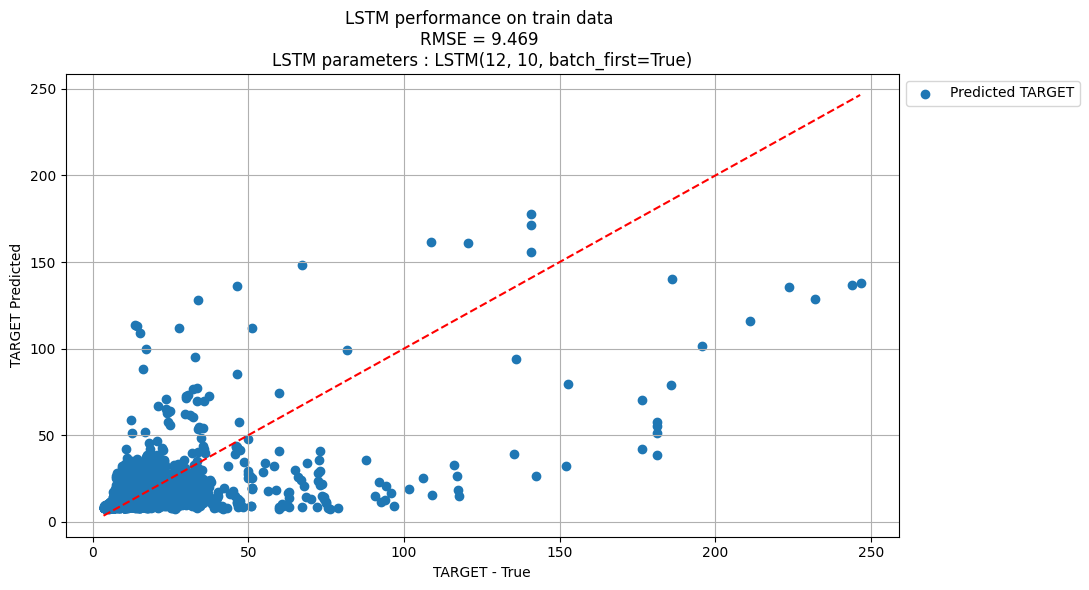

In [20]:
plt.figure(figsize=(11, 6))
plt.scatter(
    y_train_tensors.detach()
    .numpy()[:, 1]
    .ravel(),  # We convert the tensor to a numpy array for the plot since the tensor is in the right format
    predicted_train[:, -1],
    label="Predicted TARGET",
)

rmse = np.sqrt(mean_squared_error(y_train_tensors.detach().numpy()[:, 1].ravel(), predicted_train[:, -1]))

plt.plot(
    np.arange(
        np.min(y_train_tensors.detach().numpy()[:, 1].ravel()),
        np.max(y_train_tensors.detach().numpy()[:, 1].ravel()),
    ),
    np.arange(
        np.min(y_train_tensors.detach().numpy()[:, 1].ravel()),
        np.max(y_train_tensors.detach().numpy()[:, 1].ravel()),
    ),
    linestyle="--",
    color="red",
)
plt.xlabel("TARGET - True")
plt.ylabel("TARGET Predicted")
plt.title(label=f"LSTM performance on train data \nRMSE = {rmse:.3f} \nLSTM parameters : {model.__dict__['_modules']['lstm']}")
plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.grid()
plt.show()

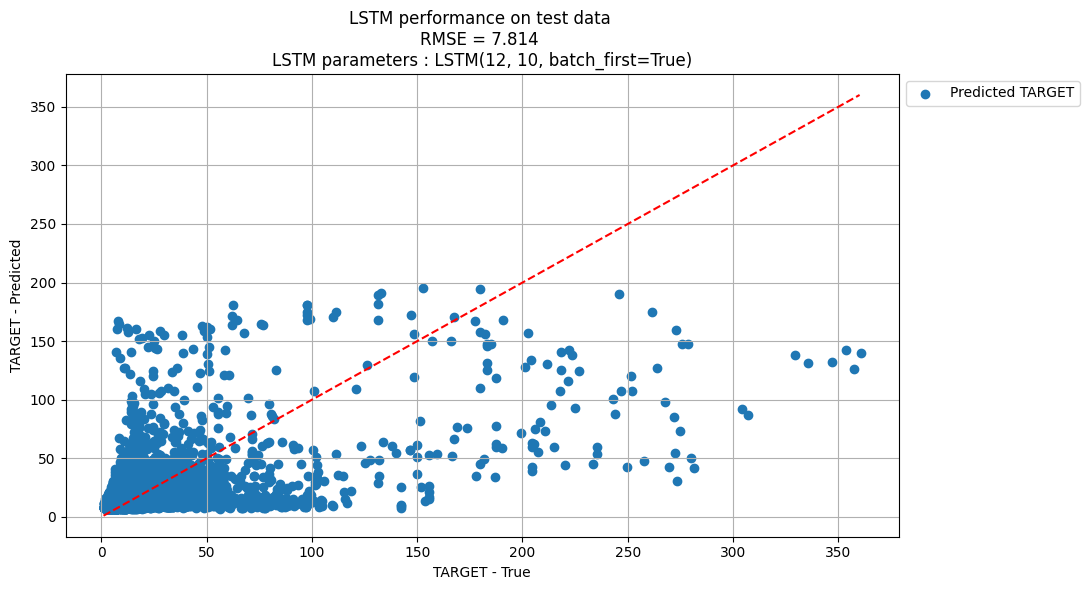

In [21]:
plt.figure(figsize=(11, 6))
plt.scatter(
    y_test_tensors.detach()
    .numpy()[:, 1]
    .ravel(),  # We convert the tensor to a numpy array for the plot since the tensor is in the right format
    predicted_test[:, -1],
    label="Predicted TARGET",
)

rmse = np.sqrt(mean_squared_error(y_test_tensors.detach().numpy()[:, 1].ravel(), predicted_test[:, -1]))

plt.plot(
    np.arange(
        np.min(y_test_tensors.detach().numpy()[:, 1].ravel()),
        np.max(y_test_tensors.detach().numpy()[:, 1].ravel()),
    ),
    np.arange(
        np.min(y_test_tensors.detach().numpy()[:, 1].ravel()),
        np.max(y_test_tensors.detach().numpy()[:, 1].ravel()),
    ),
    linestyle="--",
    color="red",
)
plt.xlabel("TARGET - True")
plt.ylabel("TARGET - Predicted")
plt.title(label=f"LSTM performance on test data \nRMSE = {rmse:.3f} \nLSTM parameters : {model.__dict__['_modules']['lstm']}")
plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.grid()
plt.show()

In [22]:
fig = FigureResampler(make_subplots(rows=1, cols=1))

y_pred_train_trace = go.Scatter(
    x=X_train.index,
    y=predicted_train[:, -1].ravel(),
    mode="lines+markers",
    marker_symbol="x",
    marker_color="blue",
    name="TARGET - Train predictions",
)
fig.add_trace(y_pred_train_trace)

y_pred_test_trace = go.Scatter(
    x=X_test.index,
    y=predicted_test[:, -1].reshape(-1, 1).ravel(),
    mode="lines+markers",
    marker_symbol="square",
    marker_color="blue",
    name="TARGET - Test predictions",
)

fig.add_trace(y_pred_test_trace)

y_true_trace = go.Scatter(
    x=df_to_parse.index,
    y=df_to_parse.loc[:, target].values.ravel(),
    mode="lines+markers",
    marker_color="green",
    name="TARGET - Raw signal",
)
fig.add_trace(y_true_trace)


fig.update_yaxes(title_text="TARGET", row=1, col=1)
fig.update_xaxes(title_text="Timeline", row=1, col=1)
fig.update_layout(template="plotly_white", height=600, title="TARGET predictions compared to true data")
fig.show_dash(port=8054)